# EE 461P: Data Science Principles
# Assignment 5
## Total points: 70
## Due: Friday, April 24th, submitted via Canvas by 11:59 pm

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Your partner needs to be from the same section. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTEID for both students.  Homework groups will be created and managed through Canvas, so please do not arbitrarily change your homework group. If you do change, let the TA know. 

Please ensure that the notebook you have uploaded on Canvas is the correct one, you could download the notebook from Canvas to double check that you have submitted the correct version on your notebook.

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

In [1]:
%matplotlib inline

### Name(s)
1. Blake Adams (baa2326)
2. Adit Jain (aj27923

The goal of this problem is to explore the effect of feature selection using  the following dataset (same as in HW 4) https://www.kaggle.com/wendykan/lending-club-loan-data

Since the dataset is really huge, we will use only a certain set of features and samples to build our model. We will also use only two classes instead of all.

The modified dataset with reduced number of samples has been prepared for your use. The file can be downloaded using the code below. You can also find it [here](https://drive.google.com/file/d/1Gv_N1rHLqDizxUck6l06BfniR30Pw0Zs/view?usp=sharing) in case you have a different environment and this code does not run.

In [2]:
%%bash
ggID='1Gv_N1rHLqDizxUck6l06BfniR30Pw0Zs'  
ggURL='https://drive.google.com/uc?export=download'  
filename="$(curl -sc /tmp/gcokie "${ggURL}&id=${ggID}" | grep -o '="uc-name.*</span>' | sed 's/.*">//;s/<.a> .*//')"  
getcode="$(awk '/_warning_/ {print $NF}' /tmp/gcokie)"  

if [ -e "${filename}" ]; then
    echo 'File already exists'
else
    curl -Lb /tmp/gcokie "${ggURL}&confirm=${getcode}&id=${ggID}" -o "${filename}"  
fi

File already exists


In [3]:
import os, sys, re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
import matplotlib.pyplot as plt

In [4]:
dataset = pd.read_csv('loan.csv')
df = dataset.fillna(0)

C:\Users\Blakes Omen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
def LoanResult(status):
    if (status == 'Fully Paid') or (status == 'Current'):
        return 1
    else:
        return 0

df['loan_status'] = df['loan_status'].apply(LoanResult)

In [6]:
df = df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
             'emp_length', 'home_ownership','annual_inc', 'verification_status', 'loan_status',
             'purpose','addr_state', 'dti','open_acc', 'pub_rec', 'revol_bal', 'revol_util', 
             'initial_list_status', 'recoveries','collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
             'application_type', 'tot_coll_amt', 'tot_cur_bal', 'avg_cur_bal', 'chargeoff_within_12_mths',
             'pub_rec_bankruptcies', 'tax_liens', 'debt_settlement_flag']]

In [7]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,last_pymnt_d,last_pymnt_amnt,application_type,tot_coll_amt,tot_cur_bal,avg_cur_bal,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,10+ years,RENT,...,Feb-2019,84.92,Individual,0.0,16901.0,1878.0,0.0,1.0,0.0,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,10+ years,MORTGAGE,...,Feb-2019,777.23,Individual,1208.0,321915.0,24763.0,0.0,1.0,0.0,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,6 years,MORTGAGE,...,Feb-2019,180.69,Individual,0.0,110299.0,18383.0,0.0,0.0,0.0,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,10+ years,MORTGAGE,...,Feb-2019,146.51,Individual,686.0,305049.0,30505.0,0.0,0.0,0.0,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,10+ years,MORTGAGE,...,Feb-2019,731.78,Individual,0.0,116007.0,9667.0,0.0,0.0,0.0,N


For simplicity, in this question, we select all columns that do not contain integer of float type of data. Then, one hot encoding is performed.

In [8]:
df_cat = df.select_dtypes(exclude=['int64', 'float64'])
df = pd.get_dummies(df, df_cat.columns.values)

Select the `loan_status` column as the target column.  
## **1. Feature Selection (30 pts)**  
**1.1 (3 pts)** Perform [Min-Max Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) on the dataset. Continue to use the scaled dataset for Q1 and Q2 of this assignment.   
**1.2 (5 pts)** Split the dataset into train and test set with 25% data in test set and print the total number of features. Use this dataset to create a `RandomForestClassifier(n_estimators=5, random_state=42)` model and print the [classification_report()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to show the precision, recall and F1 score based on the test set.  
**1.3 (6 pts)** Use $\chi^2$ test to select the top 100, 30 and 10 features using [SelectKBest](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) module. Train a random forest model and print the [classification_report()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) for each of the trained models.  
**Note:** $\chi^2$ test requires non-negative values only for all features. Since we have performed Min-Max scaling previously (where the default behavior is to scale features between 0 and 1, there should not be any problem performing this test.)   
**1.4 (6 pts)** [Plot the ROC curves](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/21_plot_roc_curve.ipynb) for all of the 4 models.  
**1.5 (8 pts)** Plot the feature importance for each of the 4 random forest models that you have trained to show the top 5 features. ([Get feature names after feature selection](https://stackoverflow.com/a/43765224), [Plot feature importance using Pandas and matplotlib](https://stackoverflow.com/a/51520906))  
**1.6 (2 pts)** What do you observe from the ROC curves?

In [9]:
#1.1
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[df_scaled.columns] = scaler.fit_transform(df_scaled[df_scaled.columns])
df_scaled.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,open_acc,pub_rec,...,last_pymnt_d_Feb-2019,last_pymnt_d_Jan-2019,last_pymnt_d_Jul-2018,last_pymnt_d_Nov-2018,last_pymnt_d_Oct-2018,last_pymnt_d_Sep-2018,application_type_Individual,application_type_Joint App,debt_settlement_flag_N,debt_settlement_flag_Y
0,0.038462,0.038462,0.045194,0.321262,0.033202,0.005637,1.0,0.018258,0.095745,0.166667,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.743590,0.743590,0.745385,0.530763,0.455427,0.009224,1.0,0.026547,0.138298,0.166667,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.102564,0.102564,0.108848,0.492991,0.091610,0.006076,1.0,0.010521,0.085106,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.076923,0.076923,0.083386,0.530763,0.070764,0.009429,1.0,0.016757,0.106383,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.743590,0.743590,0.745385,0.421729,0.427708,0.005867,1.0,0.026376,0.127660,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [10]:
#1.2

y = df_scaled['loan_status']
x = df_scaled.drop(['loan_status'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)
print("Number of features:", len(x.columns))

Number of features: 160


In [11]:
rfc = RandomForestClassifier(n_estimators = 5, random_state = 42)
rfc.fit(x_train, y_train)
forest_pred = rfc.predict(x_test)
print(classification_report(y_test, forest_pred))

# ROC score
fpr,tpr,thresholds = metrics.roc_curve(y_test,forest_pred)
roc_auc = metrics.auc(fpr,tpr)
print("ROC Score: ", roc_auc)

              precision    recall  f1-score   support

         0.0       0.73      0.34      0.46       859
         1.0       0.99      1.00      0.99     55658

    accuracy                           0.99     56517
   macro avg       0.86      0.67      0.73     56517
weighted avg       0.99      0.99      0.99     56517

ROC Score:  0.6690038481728866


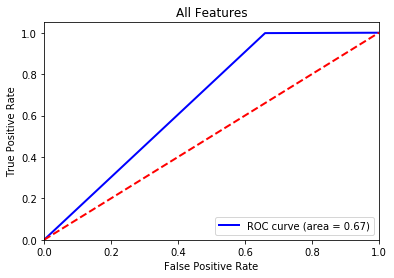

In [12]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Features')
plt.legend(loc="lower right")
plt.show()

In [13]:
#1.3 / 1.4

selector_100 = SelectKBest(chi2, k = 100)
x_100 = selector_100.fit_transform(x, y)
x_100_train, x_100_test, y_100_train, y_100_test = train_test_split(x_100,y,test_size=0.25)

selector_30 = SelectKBest(chi2, k = 30)
x_30 = selector_30.fit_transform(x, y)
x_30_train,x_30_test,y_30_train,y_30_test = train_test_split(x_30,y,test_size=0.25)

selector_10 = SelectKBest(chi2, k = 10)
x_10 = selector_10.fit_transform(x, y)
x_10_train,x_10_test,y_10_train,y_10_test = train_test_split(x_10,y,test_size=0.25)

In [14]:
rfc100 = RandomForestClassifier(n_estimators = 5, random_state = 42)
rfc100.fit(x_100_train, y_100_train)
forest_100_pred = rfc100.predict(x_100_test)
print(classification_report(y_100_test, forest_100_pred))

# ROC score
fpr100,tpr100,thresholds100 = metrics.roc_curve(y_100_test,forest_100_pred)
roc_auc_100 = metrics.auc(fpr100,tpr100)
print("ROC Score: ", roc_auc_100)

              precision    recall  f1-score   support

         0.0       0.67      0.46      0.55       832
         1.0       0.99      1.00      0.99     55685

    accuracy                           0.99     56517
   macro avg       0.83      0.73      0.77     56517
weighted avg       0.99      0.99      0.99     56517

ROC Score:  0.7278971990454548


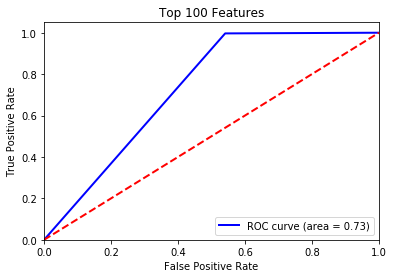

In [15]:
plt.figure()
lw = 2
plt.plot(fpr100, tpr100, color='blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_100)
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Top 100 Features')
plt.legend(loc="lower right")
plt.show()

In [16]:
rfc30 = RandomForestClassifier(n_estimators = 5, random_state = 42)
rfc30.fit(x_30_train, y_30_train)
forest_30_pred = rfc30.predict(x_30_test)
print(classification_report(y_30_test, forest_30_pred))

# ROC score
fpr30,tpr30,thresholds30 = metrics.roc_curve(y_30_test,forest_30_pred)
roc_auc_30 = metrics.auc(fpr30,tpr30)
print("ROC Score: ", roc_auc_30)

              precision    recall  f1-score   support

         0.0       0.48      0.12      0.19       824
         1.0       0.99      1.00      0.99     55693

    accuracy                           0.99     56517
   macro avg       0.73      0.56      0.59     56517
weighted avg       0.98      0.99      0.98     56517

ROC Score:  0.5591121921163159


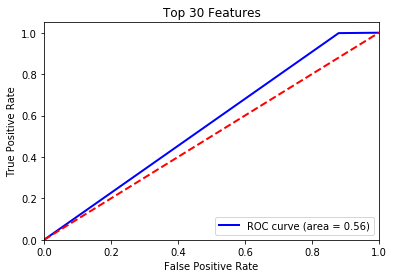

In [17]:
plt.figure()
lw = 2
plt.plot(fpr30, tpr30, color='blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_30)
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Top 30 Features')
plt.legend(loc="lower right")
plt.show()

In [18]:
rfc10 = RandomForestClassifier(n_estimators = 5, random_state = 42)
rfc10.fit(x_10_train, y_10_train)
forest_10_pred = rfc10.predict(x_10_test)
print(classification_report(y_10_test, forest_10_pred))

# ROC score
fpr10,tpr10,thresholds10 = metrics.roc_curve(y_10_test,forest_10_pred)
roc_auc_10 = metrics.auc(fpr10,tpr10)
print("ROC Score: ", roc_auc_10)

              precision    recall  f1-score   support

         0.0       1.00      0.08      0.15       847
         1.0       0.99      1.00      0.99     55670

    accuracy                           0.99     56517
   macro avg       0.99      0.54      0.57     56517
weighted avg       0.99      0.99      0.98     56517

ROC Score:  0.5419126328217237


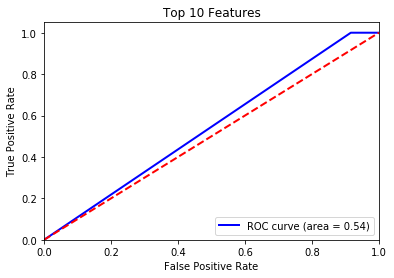

In [19]:
plt.figure()
lw = 2
plt.plot(fpr10, tpr10, color='blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_10)
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Top 10 Features')
plt.legend(loc="lower right")
plt.show()

In [20]:
print("AUC Score for All:", roc_auc_score(y_test, forest_pred))
print("AUC Score for Top 100:", roc_auc_score(y_100_test, forest_100_pred))
print("AUC Score for Top 30:", roc_auc_score(y_30_test, forest_30_pred))
print("AUC Score for Top 10:", roc_auc_score(y_10_test, forest_10_pred))

AUC Score for All: 0.6690038481728866
AUC Score for Top 100: 0.7278971990454548
AUC Score for Top 30: 0.5591121921163159
AUC Score for Top 10: 0.5419126328217237


In [21]:
#1.5

feat_importances_all = pd.Series(rfc.feature_importances_, index = x_train.columns)

cols_100 = selector_100.get_support(indices = True)
top_features_100 = x_train.iloc[:,cols_100]
feat_importances_100 = pd.Series(rfc100.feature_importances_, index = top_features_100.columns)

cols_30 = selector_30.get_support(indices = True)
top_features_30 = x_train.iloc[:,cols_30]
feat_importances_30 = pd.Series(rfc30.feature_importances_, index = top_features_30.columns)

cols_10 = selector_10.get_support(indices = True)
top_features_10 = x_train.iloc[:,cols_10]
feat_importances_10 = pd.Series(rfc10.feature_importances_, index = top_features_10.columns)


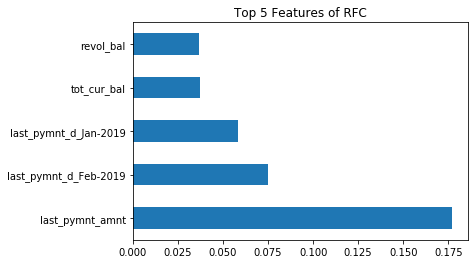

In [22]:
feat_importances_all.nlargest(5).plot(kind='barh', title = 'Top 5 Features of RFC')

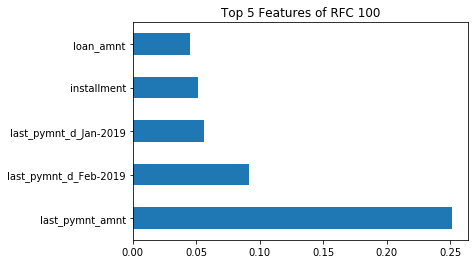

In [23]:
feat_importances_100.nlargest(5).plot(kind='barh', title = 'Top 5 Features of RFC 100')

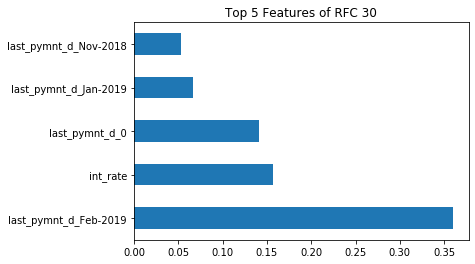

In [24]:
feat_importances_30.nlargest(5).plot(kind='barh', title = 'Top 5 Features of RFC 30')

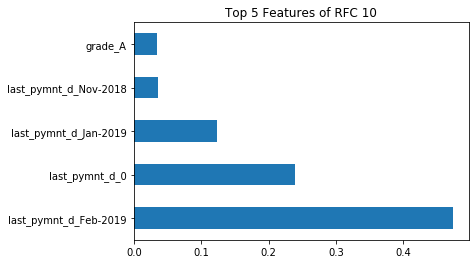

In [25]:
feat_importances_10.nlargest(5).plot(kind='barh', title = 'Top 5 Features of RFC 10')

1.6

The AUC in the ROC curves generally decreases when the amount of top features used decreases. This is because information that is potentially useful to the problem is being discarded, so the results reflect that with a smaller AUC. It seems that the top 30 features aren't even enough to convey all the underlying features used in this problem. 


# Question 2 (20 pts)
Use Principal Component Analysis (PCA) to solve this problem.  
 

**2.1 (3 pts)** Use [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and reduce the dimension of the dataset to the following components: 100, 30, 10. (3 models)  


In [26]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [27]:
# 10 components
pca10 = PCA(n_components=10)
pcomp10 = pca10.fit_transform(x)

# creating feature matrix
pca10_df = pd.DataFrame(data = pcomp10)
targetDataframe = df_scaled['loan_status']
pca10_df = pd.concat([pca10_df, targetDataframe],axis = 1)

In [28]:
# 30 components
pca30 = PCA(n_components=30)
pcomp30 = pca30.fit_transform(x)

# creating feature matrix
pca30_df = pd.DataFrame(data = pcomp30)
targetDataframe = df_scaled['loan_status']
pca30_df = pd.concat([pca10_df, targetDataframe],axis = 1)

In [29]:
# 100 components
pca100 = PCA(n_components=100)
pcomp100 = pca100.fit_transform(x)

# creating feature matrix
pca100_df = pd.DataFrame(data = pcomp100)
targetDataframe = df_scaled['loan_status']
pca100_df = pd.concat([pca100_df, targetDataframe],axis = 1)

In [30]:
y = df_scaled['loan_status']
x = df_scaled.drop(['loan_status'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)
print("Number of features:", len(x.columns))

Number of features: 160


**2.2 (6 pts)** Train Random Forest models (each using 5 decision trees (i.e. 5 estimators) for each of the reduced datasets and print the classification report similar to Q1. This will print the class-wise Precision, Recall and F1 score.

**2.3 (4 pts)** Plot the ROC curves similar to Q1 for all models (trained using dataset containing all dimensions and dataset containing reduced dimensions).  


In [31]:
# Random Forest model on original df
rfc_df = RandomForestClassifier(n_estimators = 5, random_state = 42)
rfc_df.fit(x_train, y_train)
df_pred = rfc_df.predict(x_test)
print(classification_report(y_test, df_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.39      0.49       846
         1.0       0.99      1.00      0.99     55671

    accuracy                           0.99     56517
   macro avg       0.82      0.69      0.74     56517
weighted avg       0.99      0.99      0.99     56517



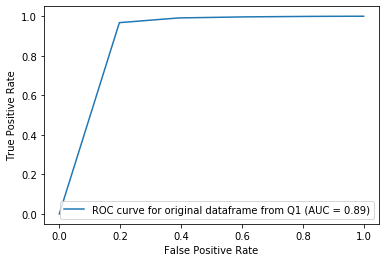

In [32]:
# plotting ROC curve for original df
disp = plot_roc_curve(rfc_df, x_test, y_test, name = 'ROC curve for original dataframe from Q1')

In [33]:
# Random Forest model on pca_10
x_pca = pca10_df.drop(['loan_status'],axis=1)
y_pca = pca10_df['loan_status']

x_train_pca,x_test_pca,y_train_pca,y_test_pca = train_test_split(x_pca,y_pca,test_size=0.25)


rfc_pca = RandomForestClassifier(n_estimators = 5, random_state = 42)
rfc_pca.fit(x_train_pca, y_train_pca)
pca_pred = rfc_pca.predict(x_test_pca)
print(classification_report(y_test_pca, pca_pred))

              precision    recall  f1-score   support

         0.0       0.13      0.01      0.02       807
         1.0       0.99      1.00      0.99     55710

    accuracy                           0.98     56517
   macro avg       0.56      0.51      0.51     56517
weighted avg       0.97      0.98      0.98     56517



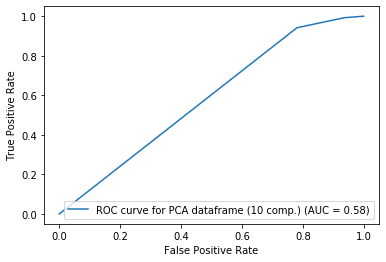

In [34]:
# plotting ROC curve for PCA 
disp = plot_roc_curve(rfc_pca, x_test_pca, y_test_pca, name = 'ROC curve for PCA dataframe (10 comp.)')

In [35]:
# Random Forest model on pca_30
x_pca = pca30_df.drop(['loan_status'],axis=1)
y_pca = df_scaled['loan_status']

x_train_pca,x_test_pca,y_train_pca,y_test_pca = train_test_split(x_pca,y_pca,test_size=0.25)


rfc_pca = RandomForestClassifier(n_estimators = 5, random_state = 42)
rfc_pca.fit(x_train_pca, y_train_pca)
pca_pred = rfc_pca.predict(x_test_pca)
print(classification_report(y_test_pca, pca_pred))

              precision    recall  f1-score   support

         0.0       0.19      0.02      0.03       855
         1.0       0.99      1.00      0.99     55662

    accuracy                           0.98     56517
   macro avg       0.59      0.51      0.51     56517
weighted avg       0.97      0.98      0.98     56517



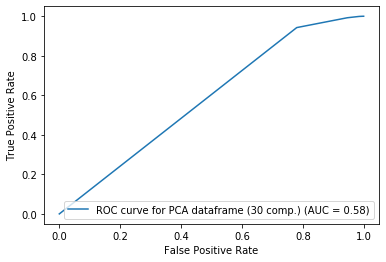

In [36]:
# plotting ROC curve for PCA 
disp = plot_roc_curve(rfc_pca, x_test_pca, y_test_pca, name = 'ROC curve for PCA dataframe (30 comp.)')

In [37]:
# Random Forest model on pca_100
x_pca = pca100_df.drop(['loan_status'],axis=1)
y_pca = df_scaled['loan_status']

x_train_pca,x_test_pca,y_train_pca,y_test_pca = train_test_split(x_pca,y_pca,test_size=0.25)


rfc_pca = RandomForestClassifier(n_estimators = 5, random_state = 42)
rfc_pca.fit(x_train_pca, y_train_pca)
pca_pred = rfc_pca.predict(x_test_pca)
print(classification_report(y_test_pca, pca_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.41      0.49       818
         1.0       0.99      1.00      0.99     55699

    accuracy                           0.99     56517
   macro avg       0.80      0.70      0.74     56517
weighted avg       0.99      0.99      0.99     56517



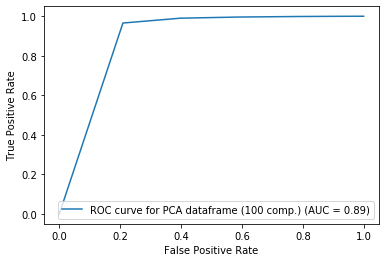

In [38]:
# plotting ROC curve for PCA 
disp = plot_roc_curve(rfc_pca, x_test_pca, y_test_pca, name = 'ROC curve for PCA dataframe (100 comp.)')

**2.4 (2 pts)** What do you observe from the ROC curves? Why do you think the classifiers based on PCA are doing worse than those based on feature selection?  


For one, the performance of the PCA classifier is also dependent on the number of components used and perhaps 10 components is too few for accuracy as opposed to the original dataset of 160 features, which may be more computationally expensive but has more data to operate on the basis of.

And though the PCA classifier utilizes the top 10 features that display the highest percentage variance explained, it may be missing out on features and data that are crucial to predicting the underlying nature of the phenomenon even though they do not contribute much variance in the target variable in the training data. 

**2.5 (5 pts)** Show the [scree plot](https://www.kindsonthegenius.com/2019/01/12/principal-components-analysispca-in-python-step-by-step/) for the first 10 components of your PCA.

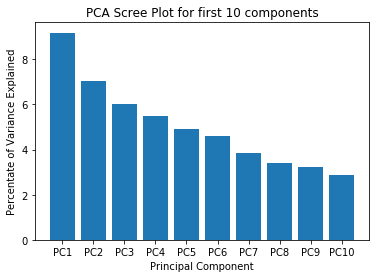

In [39]:
# graphing scree plot

percent_variance = np.round(pca10.explained_variance_ratio_* 100, decimals =2)
columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
plt.bar(x= range(1,11), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot for first 10 components')
plt.show()

# Question 3 (20 pts)

Use XGBoost to solve this problem.  
**3.1 (2 pts)** Use χ2 test to select the top 30 features using SelectKBest module. (Same as 1.3) \\
**3.2 (10 pts)** Train XGBoost models on the entire dataset and the reduced dataset (with 30 features) \\
(a) Using trees (Model A) \\
(b) Using linear regression (Model B) \\
using XGBClassifier (https://xgboost.readthedocs.io/en/latest/python/python_api.html) and you can specify the weak classifiers to be used using ***booster*** parameter in the XGBClassifier() function. \\
**3.3 (5 pts)** Plot the ROC curves similar to Q1 for all models (trained using dataset containing all dimensions and dataset containing reduced dimensions) for both models A and B.  
**3.4 (3 pts)** Which model performs better (Model A or B) and why?

In [40]:
y = df['loan_status']
x = df.drop(['loan_status'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)

In [41]:
selector_30 = SelectKBest(chi2, k = 30)
x_30_train = selector_30.fit_transform(x_train, y_train)
x_30_test = selector_30.fit_transform(x_test, y_test)

In [42]:
xgb_tree_all = xgb.XGBClassifier(booster ='gbtree', verbosity = 1, n_jobs = -1, early_stopping_rounds = 50)
xgb_tree_all.fit(x_train.to_numpy(), y_train)
tree_pred = xgb_tree_all.predict(x_test.to_numpy())

In [43]:
xgb_tree_30 = xgb.XGBClassifier(booster ='gbtree', verbosity = 1, n_jobs = -1, early_stopping_rounds = 50)
xgb_tree_30.fit(x_30_train, y_train)
tree_30_pred = xgb_tree_30.predict(x_30_test)

In [44]:
xgb_linear_all = xgb.XGBClassifier(booster ='gblinear', verbosity = 1, n_jobs = -1, early_stopping_rounds = 50)
xgb_linear_all.fit(x_train.to_numpy(), y_train)
linear_pred = xgb_linear_all.predict(x_test.to_numpy())

In [45]:
xgb_linear_30 = xgb.XGBClassifier(booster ='gblinear', verbosity = 1, n_jobs = -1, early_stopping_rounds = 50)
xgb_linear_30.fit(x_30_train, y_train)
linear_30_pred = xgb_linear_30.predict(x_30_test)

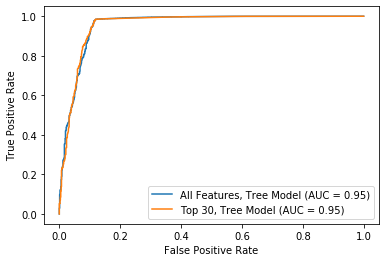

In [46]:
disp = plot_roc_curve(xgb_tree_all, x_test.to_numpy(), y_test, name = 'All Features, Tree Model')
plot_roc_curve(xgb_tree_30, x_30_test, y_test, name = 'Top 30, Tree Model', ax=disp.ax_)


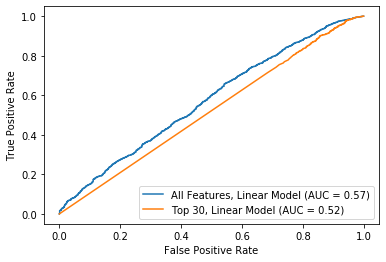

In [47]:
disp2 = plot_roc_curve(xgb_linear_all, x_test.to_numpy(), y_test, name = 'All Features, Linear Model')
plot_roc_curve(xgb_linear_30, x_30_test,  y_test, name = 'Top 30, Linear Model', ax=disp2.ax_)

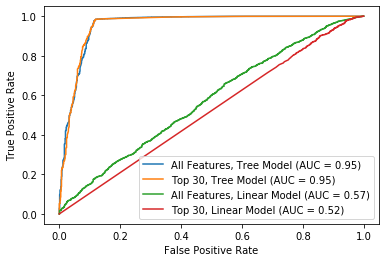

In [48]:
disp = plot_roc_curve(xgb_tree_all, x_test.to_numpy(), y_test, name = 'All Features, Tree Model')
plot_roc_curve(xgb_tree_30, x_30_test, y_test, name = 'Top 30, Tree Model', ax=disp.ax_)
plot_roc_curve(xgb_linear_all, x_test.to_numpy(), y_test, name = 'All Features, Linear Model', ax=disp.ax_)
plot_roc_curve(xgb_linear_30, x_30_test,  y_test, name = 'Top 30, Linear Model', ax=disp.ax_)

Clearly, the tree XGBClassifier performs far better than the linear one. This is likely because the linear models are not complex enough to fit the data properly. Using linear models sets a high prior that we believe the phenomenon we are trying to predict is somewhat linear in nature, which may not be the case here. Trees are also more sensitive to changes in the data than linear models. 